# Data Science Project: Assessment 3

ID: 201500568

Name: Megha Kulshrestha

This assessment has a 60% weight.

## Case study

Refer to the brief

## 1. Aims, objectives and plan (4 marks)

### a) Aims and objectives
 To build and fit a model which predicts the fraudulent "BitsBank" credit card transactions to improve the bank's market reputation that is gaining the good customer's satisfaction rating and retaining the existing customers. By using the anonymous data of customer payment's records with the target to reduce bank's loss on missing the fraudulent transaction's identification and missing to correctly label the normal (non-fraudulent) transactions. To limit the missed normal cases below 0.02% of the sum of 100 million pounds credit card transactions done by the customer using credit card. Model should maintain the wrong predictions of the missed fraudulent transactions below 25% for the sum of 200 thousand pounds transactions credit card transactions .

To pre-process the data for making it fit for modelling. To study the literature on the deviation or exception mining for selecting methods of the anomaly detection. As part of this activity implementing and comparing two techniques for the anomaly (fraud) detection and suggesting the best method out of these two. Based on the evaluation of these techniques and using performance matrices like F-Score, precision, recall, AUC, ROC or confusion matrix, reporting the results with graphs for final inferences and recommendations.

###  b) Plan
Please demonstrate how you have conducted the project with a simple Gantt chart.

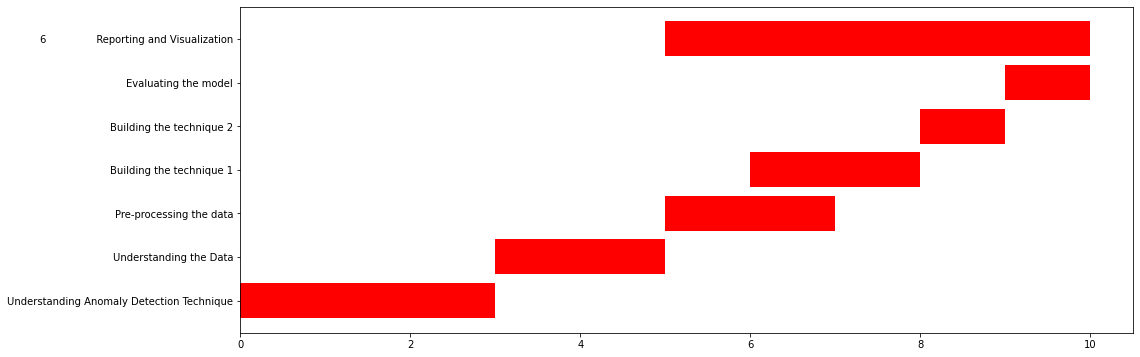

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime



data = {'task': ['Understanding Anomaly Detection Technique', 'Understanding the Data',
                 'Pre-processing the data', 'Building the technique 1', 'Building the technique 2','Evaluating the model','6                Reporting and Visualization'],
        'startdate': ['2021-09-20', '2021-09-23', '2021-09-25', '2021-09-26', '2021-09-28',
                      '2021-09-29','2021-09-25'],
        'enddate': ['2021-09-23','2021-09-25','2021-09-27','2021-09-28','2021-09-29',
                    '2021-09-30','2021-09-30'],
        'completion': [0.9, 1.0, 1.0,0.5,0.5,0.0,0.0]}
plan_data = pd.DataFrame(data)
plan_data['enddate'] = pd.to_datetime(plan_data['enddate'])
plan_data['startdate'] = pd.to_datetime(plan_data['startdate'])
proj_start_date = plan_data.startdate.min()
# number of days from project start to task start
plan_data['start_num'] = plan_data['startdate']-proj_start_date
# number of days from project start to end of tasks
plan_data['end_num'] = plan_data['enddate']-proj_start_date
# days between start and end of each task
plan_data['days_start_to_end'] = plan_data.end_num - plan_data.start_num
#Plot the Gantt Chart for the project
fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(plan_data.task, plan_data['days_start_to_end'].dt.days, left=plan_data['start_num'].dt.days, color = 'red')
plt.show()


## 2. Understanding the case study (4 marks)

###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the bank's needs. (You can include more than four points.)

200-300 words

1. Budget allotted by the bank for building an Fraud Prediction (Anomaly Detection) Application is 1 million pounds.
2. Model has to be built on historical data provided by bank. Anonymous and reduced dimensionality data is provided by applying PCA.
3. Bank has provided the limit on model prediction for maximum of 20 false negative instances out of the sum of 100 million pounds normal credit card transactions. And maximum limit for false positive cases is 5 for the sum of 200k pounds fraudulent transactions.
4. There are 28 anonymous features along with 'time' and 'amount' attributes. 'class' attribute as the label of the instance.
5. This clearly is the classification problem with two binary classes 0 - Normal Transaction and 1 - Fraudulent Transaction with imbalanced distribution of classes with fraudulent class 1 - 492 records and normal class 0 - 284316
6. Studied about various resampling techniques after splitting the data into train and test, based on the best f-score,planning for undersampling method for normal cases to decrease the imbalanced class ratio. Analyzed other methods too like oversampling.
7. For building a right fit model I will analyze following anomaly detection techniques after the data pre-processing steps -
     i. One Class Classification - SVM
    ii. Reconstruction - Autoencoder - To compress the attributes by encoding to lower dimensions representation of training data.
   iii. XGBOOST Anamoly detection model
8. Comparing the performance of Autoencoder reconstruction based method with XGBOOST ensembling method.

## 3. Pre-processing applied (20 marks)
Enter the code in the cells below to execute each of the stated sub-tasks. 


###  a) Preparing the labels appropriately

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import seaborn as sns

cc_transactions = pd.read_csv('C:/5122 Data Science/Assignment/creditcard.csv') # 284807
#Converting to lower case to avoid mistakes in column reference with different type of case.
cc_transactions.columns = map(str.lower, cc_transactions.columns)
#Renamed the class column to more meaningful column name
cc_transactions.rename(columns={'class':'fraud'}, inplace=True)
print(cc_transactions.head())

   time        v1        v2        v3        v4        v5        v6        v7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         v8        v9  ...       v21       v22       v23       v24       v25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        v26       v27       v28 

###  b) Removing synonymous and noisy attributes
Time attribute does not contribute in predicting the pattern of fraud transactions based on initial understanding.

In [135]:
from collections import Counter

#Time attribute does not contribute as the common values is not more than 6 in predicting the pattern of fraud transactions.
time_list = list(cc_transactions.loc[cc_transactions.fraud == 1].time.values)
time_counted_list = Counter(time_list)
time_counted_list.most_common(40)

print(time_counted_list)

cc_transactions = cc_transactions.drop('time', axis = 1)
cc_transactions.columns

Counter({68207.0: 6, 84204.0: 4, 85285.0: 4, 93853.0: 4, 93860.0: 4, 93879.0: 4, 94362.0: 4, 148053.0: 2, 406.0: 1, 472.0: 1, 4462.0: 1, 6986.0: 1, 7519.0: 1, 7526.0: 1, 7535.0: 1, 7543.0: 1, 7551.0: 1, 7610.0: 1, 7672.0: 1, 7740.0: 1, 7891.0: 1, 8090.0: 1, 8169.0: 1, 8408.0: 1, 8415.0: 1, 8451.0: 1, 8528.0: 1, 8614.0: 1, 8757.0: 1, 8808.0: 1, 8878.0: 1, 8886.0: 1, 9064.0: 1, 11080.0: 1, 11092.0: 1, 11131.0: 1, 11629.0: 1, 11635.0: 1, 12093.0: 1, 12095.0: 1, 12393.0: 1, 12597.0: 1, 13126.0: 1, 13323.0: 1, 14073.0: 1, 14152.0: 1, 15817.0: 1, 17187.0: 1, 17220.0: 1, 17230.0: 1, 17520.0: 1, 17838.0: 1, 18088.0: 1, 18399.0: 1, 18675.0: 1, 18690.0: 1, 19762.0: 1, 20011.0: 1, 20332.0: 1, 20451.0: 1, 20931.0: 1, 21046.0: 1, 21419.0: 1, 21662.0: 1, 25095.0: 1, 25198.0: 1, 25231.0: 1, 25254.0: 1, 25426.0: 1, 26523.0: 1, 26556.0: 1, 26585.0: 1, 26833.0: 1, 26863.0: 1, 26899.0: 1, 26931.0: 1, 26961.0: 1, 27163.0: 1, 27187.0: 1, 27219.0: 1, 27252.0: 1, 27784.0: 1, 28143.0: 1, 28242.0: 1, 28625.0: 

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount', 'fraud'],
      dtype='object')

###  c) Dealing with missing values
There are no missing and null values in the given dataset.

In [136]:
print(cc_transactions.isna().values.any())
print(cc_transactions.isnull().values.any())

False
False


###  d) Rescaling if necessary


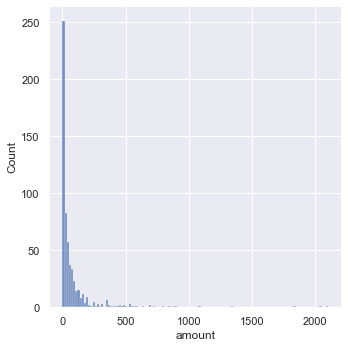

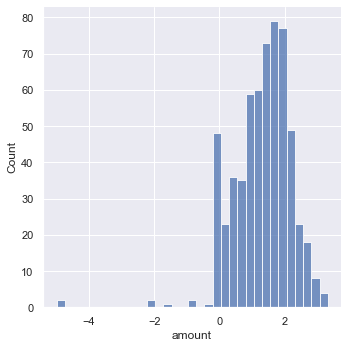

In [137]:
# To check the variability of
RANDOM_STATE = 65
#Right Skewed amount column
sns.displot(data=cc_transactions.sample(600, random_state=RANDOM_STATE), x="amount")
#Scaled the amount column using log based scaling to get the normally distributed column
cc_transactions['amount'] = np.log10(cc_transactions.amount+0.00001)
sns.displot(data=cc_transactions.sample(600, random_state=RANDOM_STATE), x="amount")

In [138]:
#Undersampling the imbalanced class
%matplotlib inline
#Splitting Class
RATIO_TO_FRAUD =  15
fraud =  cc_transactions[cc_transactions.fraud == 1]
normal = cc_transactions[cc_transactions.fraud == 0]
print('skew = {}'.format(len(fraud)/float(len(cc_transactions))))
normal_undersample = normal.sample(int(len(fraud) * RATIO_TO_FRAUD), random_state= RANDOM_STATE)
#Concatenating undersampled normal records with
undersampled_normal_fraud = pd.concat([fraud, normal_undersample])
features, label = undersampled_normal_fraud.drop('fraud', axis = 1), undersampled_normal_fraud.fraud.values

skew = 0.001727485630620034


### e) Other - Normalizing and Standardizing for handling randomness to optimize by converging the gradient descent.
#We can tell the data is slightly more uniform and proportionally distributed.
#The ranges were also shrunk to fit between 0 and 1.


0    84315
1      492
Name: fraud, dtype: int64


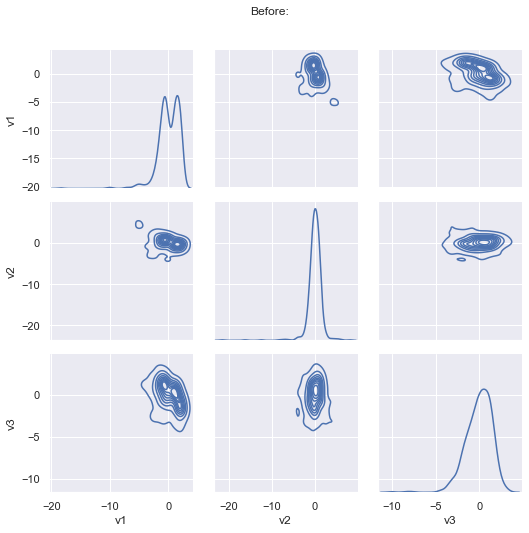

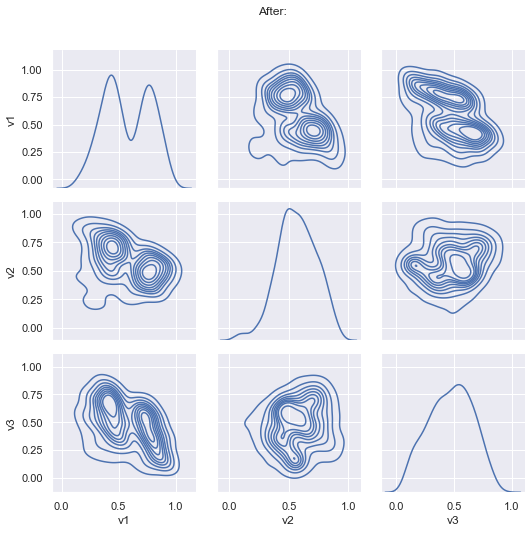

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# shuffle our training set
TRAINING_SAMPLE = 200000
normal = normal.sample(frac=1).reset_index(drop=True)

# training set: exclusively non-fraud transactions
X_train = normal.iloc[:TRAINING_SAMPLE].drop('fraud', axis=1)

# testing  set: the remaining non-fraud + all the fraud
X_test = normal.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)
print(X_test.fraud.value_counts())

X_train, X_validate = train_test_split(X_train, test_size=0.25, random_state=RANDOM_STATE)
X_test, Y_test =  X_test.drop('fraud', axis = 1), X_test.fraud.values

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

#Before
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_STATE))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

#After

g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=list(undersampled_normal_fraud.drop('fraud', axis=1).columns)).iloc[:,:3].sample(600, random_state=RANDOM_STATE))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);


## 4. Technique 1 (20 marks)

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process

100-200 words
                                       Autoencoder Anomaly Detection Technique
Autoencoder model is artificial neural network model selects the most important features to be used for finding the commonalities between the similar type of instances first by reducing the input features in hidden layers(perceptrons) and then reconstructing it with same number of output features(Model provides the dimensionality reduction which is the benefit over the distance based models like KNN). As identified above this is the imbalanced class classification problem and autoencoder trains the model in unsupervised manner. Non-linear transformations with non-linear activations can be performed by autoencoder in multiple layers. Reconstruction error is less in training the model through normal instances and high in anomalous instances. Autoencoder can learn the wide variety of representations of the normal class. Autoencoder Process Flow diagram is shown below.

![Autoencoder Process Flow](Autoencoder.png)




Enter the correct code in the cells below to execute each of the stated sub-tasks.
### b) Setting hyper parameters with rationale


In [141]:
import tensorflow as tf
# data dimensions // hyperparameters
input_dim = X_train_transformed.shape[1]
print(input_dim)
BATCH_SIZE = 256
EPOCHS = 500

# ELU - Exponential Linear Unit
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),

    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 8)               

### c) Optimising hyper parameters


In [142]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
print(datetime.now().strftime('%Y%m%d%H%M'))

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=False,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

202109302308
Epoch 1/500
586/586 [==============================] - 5s 6ms/step - loss: 0.0343 - acc: 0.2311 - val_loss: 0.0159 - val_acc: 0.2412

In [143]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

### d) Performance metrics for training

84315
492


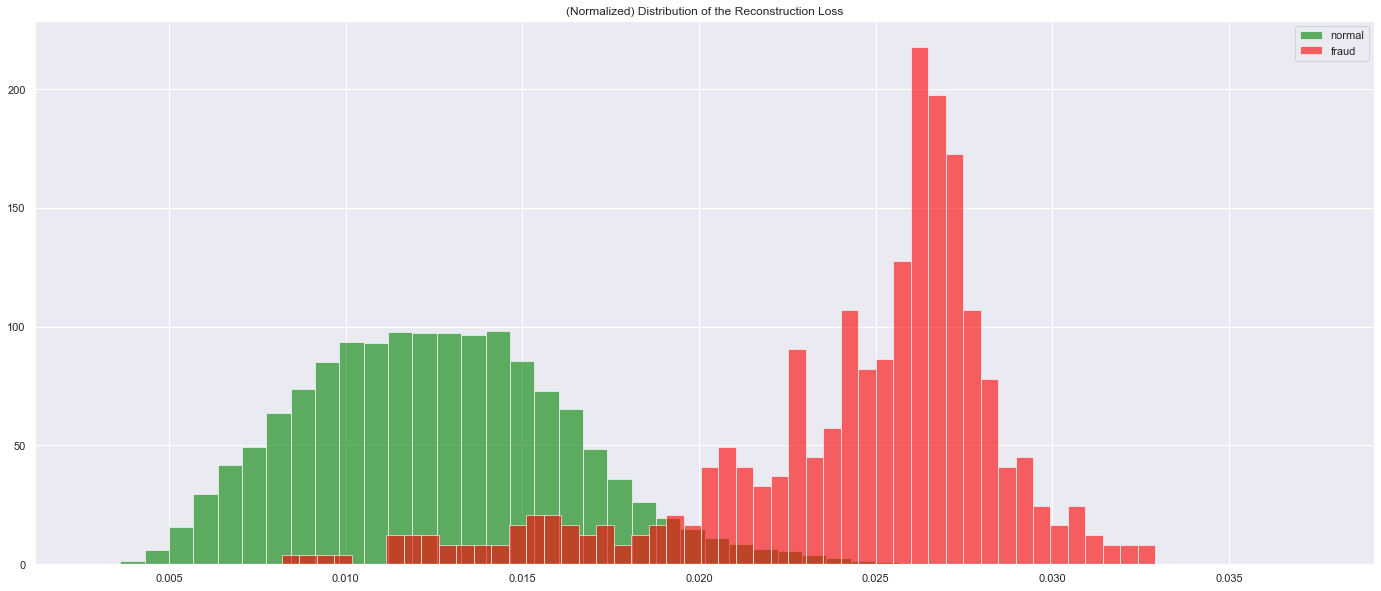

In [144]:
mse =  np.mean(np.power(X_test_transformed - reconstructions,2),axis=1)

clean = mse[Y_test==0]
fraud = mse[Y_test==1]
print(len(clean))
print(len(fraud))

fig, ax = plt.subplots(figsize=(24,10))

ax.hist(clean, bins=50, density=True, label="normal", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [145]:
THRESHOLD = 3
#Mean absolute deviation using median of the data |Y - Ybar| and m as the median of the points
#Used for idntifying outliers
"""https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")


Detected 596 outliers in a total of 84,807 transactions [0.70%].


In [146]:
from sklearn.metrics import (confusion_matrix,
                             average_precision_score)

# get (mis)classification
cm = confusion_matrix(Y_test, outliers)

# true/false positives/negatives
(tn, fp,
 fn, tp) = cm.flatten()

precision = tp/(tp + fp)
recall = tp/(fn+tp)
fscore = 2 * precision * recall/(precision + recall)

print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught successfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
#F-Measure = (2 * Precision * Recall) / (Precision + Recall)
print(fscore)
print('AUPRC = {}'.format(average_precision_score(Y_test, outliers)))

The classifications using the MAD method with threshold=3 are as follows:
[[84039   276]
 [  172   320]]

% of transactions labeled as fraud that were correct (precision): 320/(276+320) = 53.69%
% of fraudulent transactions were caught successfully (recall):    320/(172+320) = 65.04%
0.5882352941176471
AUPRC = 0.3512396802767652


## 5. Technique 2 (20 marks)

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process

100-200 words
XGBoost is the ensemble method which combines the base classifiers to perform better than individual classifiers. With the generalization capabilities , imbalanced dataset and insufficiently labeled data, XGBoost is the semi-supervised method of stacking which uses the unsupervised classifiers(as they perform well with imbalanced dataset) outputs as the supervised classifier input. Also, XGBoost optimizes the model and computation performance. XGBoost uses the regularization to avoid overfitting with better results and short execution time. XGBoost also generates the feature rankings for feature pruning for the tree. XGBoost, allows for weighting the positive class more compared to the negative class. Transformation Outlier Score (TOS) is calculated for each unsupervised classifier and then the best scores are selected to provide that as the input to supervised classifier.

![Process Flow XGBOOST](XGBOOST.jpg)


Enter the correct code in the cells below to execute each of the stated sub-tasks.
### b) Setting hyper parameters with rationale

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
X = cc_transactions
Y =  X['fraud']
del X['fraud']

### c) Optimising hyper parameters
#Split the data into training and test sets in a 80:20 ratio


In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

weights = (Y==0).sum()/(1.0 *  (Y==1).sum())
print(weights)
xgb_classifier = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
xgb_prediction = xgb_classifier.fit(X_train, Y_train).predict_proba(X_test)


577.8760162601626


C:\Users\Megha\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.8748917762705053


### d) Performance metrics for training

In [100]:
print('AUPRC = {}'.format(average_precision_score(Y_test, xgb_prediction[:,1])))



AUPRC = 0.8748917762705053


## 6. Comparison of metrics performance for testing (16 marks)
Enter the correct code in the cells below to execute each of the stated sub-tasks. 


### a) Use of cross validation for both techniques to deal with over-fitting

In [108]:
#XGBoost CV implementation
from sklearn.model_selection import StratifiedKFold, GridSearchCV
search_verbose = 1
#Reduced (Undersample for 5000 records) as the size is too large
X_CV = X.iloc[:,:].sample(5000, random_state=RANDOM_STATE)
Y_CV = Y.sample(5000, random_state=RANDOM_STATE)

params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
}
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X_CV,Y_CV), verbose=search_verbose)
grid_search.fit(X_CV, Y_CV)
print("Best estimator: ")
print(grid_search.best_estimator_)
print("Parameters: ", grid_search.best_params_)
print("Highest AUC: %.2f" % grid_search.best_score_)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  4.9min finished


Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 0.6}
Highest AUC: 0.50


### b) Comparison with appropriate metrics for testing

### c) Model selection (ROC or other charts)

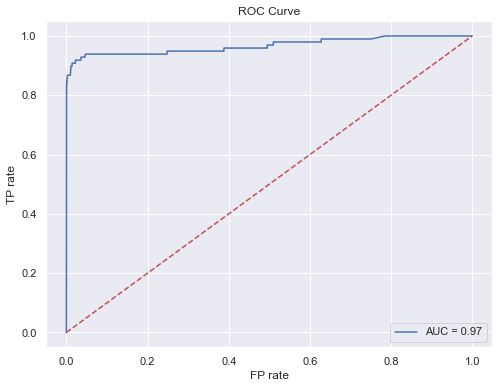

In [131]:

from sklearn import metrics

model_params = grid_search.best_params_
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train, Y_train)
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(Y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

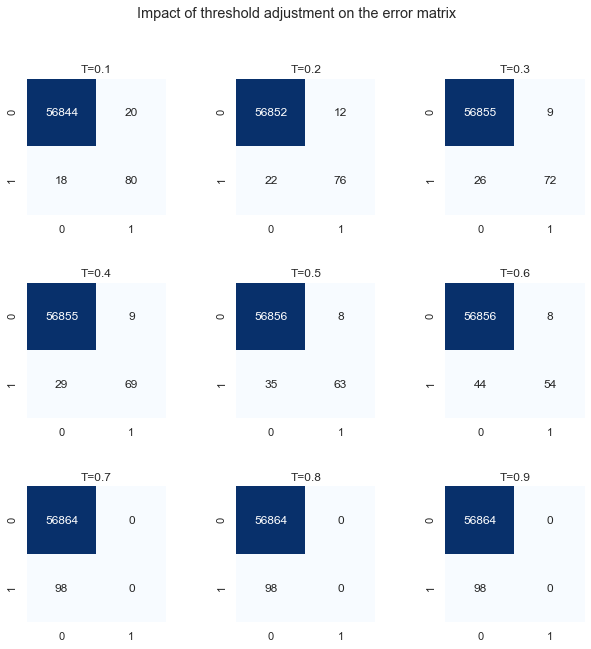

In [132]:
y_pred = model.predict_proba(X_test)[:,1]
fig, axes = plt.subplots(3,3, figsize=(10,10))
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10
    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(Y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

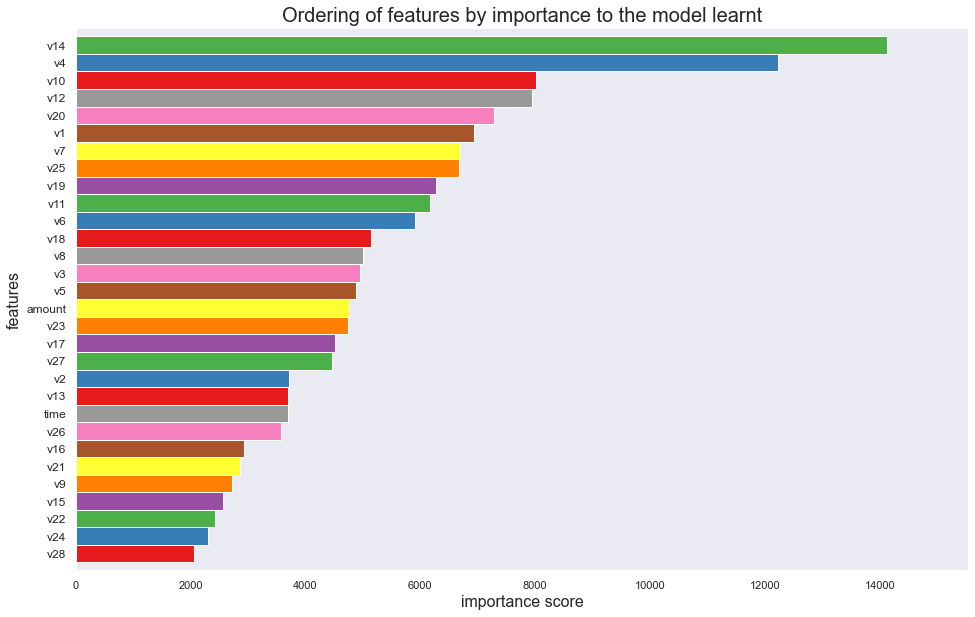

In [147]:
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_classifier1, height = 1, color = colours, grid = False,
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

## 7. Final recommendation of best model (8 marks)

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

100-200 words

I will be recommending XGBoost Modelling for anomaly detection because it the ensembling method and would give the better performance. However the autoencoder performance can improved by adding more layers in the model architecture.
Initially the model is predicting the fraud cases correctly , but after 90% of training reach FP rates started increasing in XGBoost with 0.97 AUC. Still XGBoost Model shows the good performance. Because the average precision of XGBoost is approx. 87%, but in the case of Autoencoder the average precision is only 53%  with recall = 65.04% with F- score approx. 0.58. Average Precision  = 0.35 which is very less to choose this model.
According to confusion Matrix the result for Autoencoder is tn = 84039,  fp = 276, fn =  172 , tp = 320]] where it is evident that the fn and fp is high hence the scores are less. In case of autoencoder the recall rate is high = 82.72 which is only one positive point. Whereas in the case of XGBoost model in T = 0.3 the fn and fp cases are very low which gives the strong reason to select and recommend the bank to use XGBoost model.  It still hasn't reached the required threshold value but can be achieved by fine tuning the model. Increasing the threshold further leads to missing more fraudulent transactions, and reducing it lower almost doubles the number false positives.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

100-200 words

From the business point of view the results coming from the model is inclined towards the positive side because 87% of the time the results are accurate that means the true positive are proportionally more than the false positive cases.
Also the bank should be suggested to implement and deploy this model for more validation and testing.
The results also suggests that after model predicts the normal cases in far more better way than the fraudulent cases.
Results shows that the 87% precision can be improved before the deployment in production.
V2, V14 , V26 are more prominent attributes in forming the pattern.


## 8. Conclusion (8 marks)

### a) What has been successfully accomplished and what has not been successful?
100-300 words

1. Exploratory data analysis is done in quite a good way.
2. Understanding sampling techniques implemented
3. XGBoost Modelling and Autoencoder Model Training is accomplished.
4. Confusion Matrix and other performance metrics are generated.

5. Cross Validation for Autoencoder anomaly detection technique.
6. Comparison of metrics is not done.
7. More data analysis should be done on time and amount attributes, to know how it is affecting the pattern in differentiating fraud cases with the normal cases.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?
100-300 words

1. Practiced different techniques and factors affecting the model.
2. Larger dataset would provide the more appropriate results.
3. Tuned the model with more other hyper parameter values
4. Asked more question  related to domain to get the clarity for dimensionality reduction
5. From technical perspective explored various resampling techniques like undersampling and oversampling.
6. From analytical perspective, focused more on impact of the performance of model.
7. Requirements refinement and understanding could be done early.

### c) Provide a wish list of future work that you would like to do
100-200 words

1. Exploring other anomaly detection technique like One Class Classification SVM, KNN, Mahalanobis Distance etc
2. Autoencoder model architecture redesigning with more layers to fine tune the performance.
3. Cross Validation and metrics comparison in detail.
4. SMOTE oversampling to try to train the model effectively
5. Time and amount attributes can be explored with multiple perspective.
6. XGBoost hyperparameter tuning with different set of data to validate the performance.
